# Big Data Analytics Project
### Implemented by Simona Scala - A.Y. 2022/23

The implementation of this project involves exploring data-mining techniques for an online retailer using the pyspark library, following the methodology outlined by [Chen et al.](https://dx.doi.org/10.1057/dbm.2012.17). Their article primarily aims to enhance business understanding of its customers and to utilize data mining techniques to segment customers based on the Recency-Frequency-Monetary (RFM) model.

## Imports

In [1]:
!pip install pyspark
!pip install wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285397 sha256=bb8d6a343f659783d79b69e2d67bb3a200e3ac3c0c18aa4d42ccd75c52ac3c63
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=8b9b6d1c9d1cd13a4a4415f8920ba83f3f5822e9bec36456fcd69fbce71d4379
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import wget
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format, datediff, current_date, max, count, sum
from pyspark.ml.feature import RFormula, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator

seed = 42   # set the random seed

## Instantiating a Spark Session

In [3]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
type(spark)

pyspark.sql.session.SparkSession

## Downloading the Dataset

In [5]:
dataset_url = 'https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip'
wget.download(dataset_url)
zip_dataset_path = 'online+retail+ii.zip'
with ZipFile(zip_dataset_path, 'r') as zObject:
  zObject.extractall()

os.remove('online+retail+ii.zip')

## Loading the Dataset into a Spark Dataframe

In [6]:
df_pandas = pd.read_excel('online_retail_II.xlsx')
df = spark.createDataFrame(df_pandas)

## Data Exploration

In [7]:
df.show()

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|    13085.0|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|    22041|RECORD FRAME 7" S...|      48|2009-12-01 07:45:00|  2.1|    13085.0|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00| 1.25|    13085.0|United Kingdom|
| 489434|    22064|PINK DOUGHNUT TRI...|      24|2009-12-01 07:45:00| 1.65|    13085.0|United Kingdom|
| 489434|    21871| SAVE THE PLANET MUG|      24|2009-12-01 07:45:00| 1.2

In [8]:
df.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)



In [9]:
print('Number of features: ', len(df.columns))

Number of features:  8


Upon analyzing the data, it becomes evident that the dataset has undergone modifications over the years. Contrary to the original research's suggestion of 11 variables, the current dataset comprises only 8 variables. Notably, the variables `Address Line 1`, `Address Line 2`, `Address Line 3`, and `PostCode` have been substituted with the variable `Customer ID`. It is important to highlight that the variable PostCode played a crucial role for the business, as it provided vital information that enabled the identification and tracking of individual consumers in the UK. This information facilitated in-depth analyses in their study. One potential reason for replacing these variables could be the growth in the number of customers, making it more convenient to utilize a `Customer ID` for easier recognition of clients, even if they originate from other countries.


In [10]:
print('Number of instances:', df.count())

Number of instances: 525461


## Data Pre-Processing

To enable further computation, it is necessary to eliminate all rows that contain `null` values in the columns `Quantity`, `InvoiceDate`, `Price`, `Customer ID`, and `Country`. These specific columns must be devoid of any null values to proceed with the calculations.

In [11]:
columns_to_check = ['Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']
df = df.dropna(subset=columns_to_check)
print('Number of instances:', df.count())

Number of instances: 417534


Furthermore, we proceed with the elimination of all rows where the `Quantity` value is less than 0, as negative values hold no meaningful interpretation in this context.

In [12]:
df = df.filter(df.Quantity > 0)
print('Number of instances:', df.count())

Number of instances: 407695


In accordance with Chen et al.'s paper, we generate a new aggregated variable called `Amount` by multiplying the values of `Quantity` with `Price`. This computation results in the total amount of money spent on each product/item within every transaction.

In [13]:
df = df.withColumn('Amount', (col('Quantity')*col('Price')).cast('float'))
df.show()

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|Amount|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|    13085.0|United Kingdom|  83.4|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|  81.0|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|  81.0|
| 489434|    22041|RECORD FRAME 7" S...|      48|2009-12-01 07:45:00|  2.1|    13085.0|United Kingdom| 100.8|
| 489434|    21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00| 1.25|    13085.0|United Kingdom|  30.0|
| 489434|    22064|PINK DOUGHNUT TRI...|      24|2009-12-01 07:45:00| 1.65|    13085.0|United Kingdom|  39.6|
| 489434| 

Next, we separate the variable `InvoiceDate` into two variables `Date` and `Time`. This allows different transactions created by the same consumer on the same day but at different times to be treated separately.

In [14]:
df = df.withColumn('Date', date_format('InvoiceDate', 'yyyy-MM-dd'))
df = df.withColumn('Time', date_format('InvoiceDate', 'HH:mm:ss'))
df = df.drop('InvoiceDate')
df.show()

+-------+---------+--------------------+--------+-----+-----------+--------------+------+----------+--------+
|Invoice|StockCode|         Description|Quantity|Price|Customer ID|       Country|Amount|      Date|    Time|
+-------+---------+--------------------+--------+-----+-----------+--------------+------+----------+--------+
| 489434|    85048|15CM CHRISTMAS GL...|      12| 6.95|    13085.0|United Kingdom|  83.4|2009-12-01|07:45:00|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12| 6.75|    13085.0|United Kingdom|  81.0|2009-12-01|07:45:00|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12| 6.75|    13085.0|United Kingdom|  81.0|2009-12-01|07:45:00|
| 489434|    22041|RECORD FRAME 7" S...|      48|  2.1|    13085.0|United Kingdom| 100.8|2009-12-01|07:45:00|
| 489434|    21232|STRAWBERRY CERAMI...|      24| 1.25|    13085.0|United Kingdom|  30.0|2009-12-01|07:45:00|
| 489434|    22064|PINK DOUGHNUT TRI...|      24| 1.65|    13085.0|United Kingdom|  39.6|2009-12-01|07:45:00|
| 489434| 

Furthermore, for improved dataset segmentation, the analysis is narrowed down to consumers exclusively from the United Kingdom. Consequently, all transactions not linked to the United Kingdom are filtered out from the research.

In [15]:
df = df.filter(df.Country.like("United Kingdom"))
print('Number of instances:', df.count())

Number of instances: 370951


Now, we embark on preparing the dataset for segmentation. First, we sort the dataset by `Customer ID` and create three fundamental aggregated variables: `Recency`, `Frequency`, and `Monetary`. These variables are computed on a per Customer ID basis and hold the following meanings:

- Recency: This variable signifies the number of days elapsed since a customer's most recent interaction or transaction with the business.
- Frequency: The Frequency variable indicates the count of interactions or transactions a customer has conducted with the business during a specific timeframe. It encompasses the number of transactions, visits, or actions within the defined period.
- Monetary: The Monetary variable reflects the total monetary value or amount spent by a customer within the specified time frame. It encapsulates all the expenditures made by the customer.

In [16]:
df_agg = df.groupby("Customer ID").agg(
    datediff(current_date(), max("Date")).alias("Recency"),
    count("Invoice").alias("Frequency"),
    sum("Amount").cast('float').alias("Monetary")
)
df_agg.show()

+-----------+-------+---------+---------+
|Customer ID|Recency|Frequency| Monetary|
+-----------+-------+---------+---------+
|    12346.0|   4777|       33|   372.86|
|    12608.0|   4652|       16|   415.79|
|    12745.0|   4734|       22|   723.85|
|    12746.0|   4788|       17|   254.55|
|    12747.0|   4617|      154|5080.5303|
|    12748.0|   4613|     2634| 22879.66|
|    12749.0|   4647|      139|  2806.48|
|    12777.0|   4705|       26|   519.45|
|    12819.0|   4706|       19|   540.52|
|    12820.0|   4645|      101|  1747.18|
|    12821.0|   4859|        7|   128.08|
|    12823.0|   4642|       13|   4742.0|
|    12825.0|   4769|       24|   518.63|
|    12826.0|   4613|       75|  1481.03|
|    12829.0|   4798|        8|92.299995|
|    12831.0|   4711|       13|   236.06|
|    12835.0|   4675|      620|  6043.31|
|    12836.0|   4637|      239|  3972.76|
|    12837.0|   4817|       80|   554.31|
|    12838.0|   4621|      300|  2715.35|
+-----------+-------+---------+---

In [17]:
print('Number of instances in the aggregated dataset:', df_agg.count())

Number of instances in the aggregated dataset: 3971


At this point, we are ready to utilize the RFormula to define the clustering formula, which includes specifying the features to be employed in the process. The RFormula will assemble these features into a vector, enabling us to perform clustering based on the selected variables.

In [18]:
rf = RFormula(formula="~ Recency + Frequency + Monetary")
rf_fit = rf.fit(df_agg)
rf_transfd = rf_fit.transform(df_agg)
rf_transfd.show()

+-----------+-------+---------+---------+--------------------+
|Customer ID|Recency|Frequency| Monetary|            features|
+-----------+-------+---------+---------+--------------------+
|    12346.0|   4777|       33|   372.86|[4777.0,33.0,372....|
|    12608.0|   4652|       16|   415.79|[4652.0,16.0,415....|
|    12745.0|   4734|       22|   723.85|[4734.0,22.0,723....|
|    12746.0|   4788|       17|   254.55|[4788.0,17.0,254....|
|    12747.0|   4617|      154|5080.5303|[4617.0,154.0,508...|
|    12748.0|   4613|     2634| 22879.66|[4613.0,2634.0,22...|
|    12749.0|   4647|      139|  2806.48|[4647.0,139.0,280...|
|    12777.0|   4705|       26|   519.45|[4705.0,26.0,519....|
|    12819.0|   4706|       19|   540.52|[4706.0,19.0,540....|
|    12820.0|   4645|      101|  1747.18|[4645.0,101.0,174...|
|    12821.0|   4859|        7|   128.08|[4859.0,7.0,128.0...|
|    12823.0|   4642|       13|   4742.0|[4642.0,13.0,4742.0]|
|    12825.0|   4769|       24|   518.63|[4769.0,24.0,5

In the context of clustering, it is essential to scale the features to ensure they have comparable ranges. Scaling helps prevent any particular feature from dominating the distance calculations used in clustering algorithms such as the k-means algorithm. A commonly used method to standardize the features is by employing the `StandardScaler`.

The `StandardScaler` in PySpark is a data preprocessing technique that transforms the features of the dataset by subtracting the mean and dividing by the standard deviation of each feature. This transformation centers the data around zero and scales it to have unit variance. By doing so, all the features are brought to a similar scale, which ensures that their impact on the clustering process is balanced and none of them disproportionately influences the results.

In summary, using the `StandardScaler` in PySpark is a crucial step to normalize the features, making them comparable and avoiding biased clustering outcomes due to feature magnitudes.

In [19]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
rf_transfd = scaler.fit(rf_transfd).transform(rf_transfd)
rf_transfd.show()

+-----------+-------+---------+---------+--------------------+--------------------+
|Customer ID|Recency|Frequency| Monetary|            features|      scaledFeatures|
+-----------+-------+---------+---------+--------------------+--------------------+
|    12346.0|   4777|       33|   372.86|[4777.0,33.0,372....|[49.1650914958890...|
|    12608.0|   4652|       16|   415.79|[4652.0,16.0,415....|[47.8785860663336...|
|    12745.0|   4734|       22|   723.85|[4734.0,22.0,723....|[48.7225336281219...|
|    12746.0|   4788|       17|   254.55|[4788.0,17.0,254....|[49.2783039736899...|
|    12747.0|   4617|      154|5080.5303|[4617.0,154.0,508...|[47.5183645460581...|
|    12748.0|   4613|     2634| 22879.66|[4613.0,2634.0,22...|[47.4771963723123...|
|    12749.0|   4647|      139|  2806.48|[4647.0,139.0,280...|[47.8271258491514...|
|    12777.0|   4705|       26|   519.45|[4705.0,26.0,519....|[48.4240643684651...|
|    12819.0|   4706|       19|   540.52|[4706.0,19.0,540....|[48.4343564119

## Clustering

Selecting the optimal value of `k`, the number of clusters, is a crucial step in clustering analysis. The silhouette score serves as a metric to evaluate how well each object within the dataset belongs to its respective cluster compared to other clusters. A higher silhouette score indicates that the clusters are well-defined and distinct. By computing the silhouette scores for different `k` values, we can identify the one that maximizes the score, indicating the most suitable number of clusters for our dataset. This process ensures that we achieve meaningful and well-separated clusters, enhancing the effectiveness of our clustering analysis.

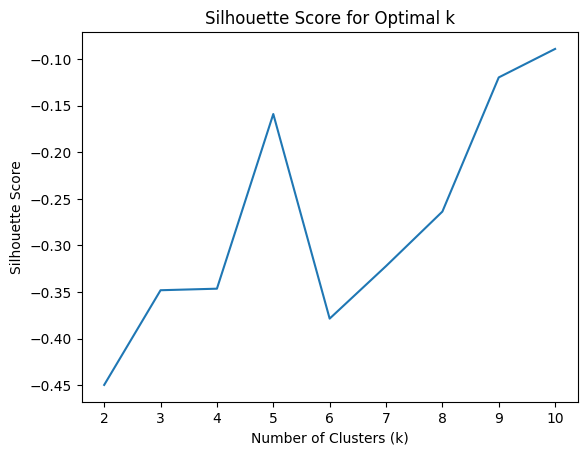

In [20]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=seed)
    model = kmeans.fit(rf_transfd)
    clusters = model.transform(rf_transfd)
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(clusters)
    silhouette_scores.append(silhouette_score)

# Plot the silhouette scores for different k
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.show()

We assign the value of `k` that yields the highest silhouette score.

In [21]:
k = silhouette_scores.index(np.max(silhouette_scores)) + 2

We are now ready to implement the k-means clustering algorithm and proceed to fit the k-means model to the scaled dataset. Once the k-means model is trained, the data points are assigned cluster labels by transforming them with the trained model.

In [22]:
kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=seed)
kmeans_model = kmeans.fit(rf_transfd)
clusters = kmeans_model.transform(rf_transfd)
clusters.select("Recency", "Frequency", "Monetary", "prediction").show()

+-------+---------+---------+----------+
|Recency|Frequency| Monetary|prediction|
+-------+---------+---------+----------+
|   4777|       33|   372.86|         3|
|   4652|       16|   415.79|         8|
|   4734|       22|   723.85|         3|
|   4788|       17|   254.55|         3|
|   4617|      154|5080.5303|         0|
|   4613|     2634| 22879.66|         5|
|   4647|      139|  2806.48|         0|
|   4705|       26|   519.45|         8|
|   4706|       19|   540.52|         8|
|   4645|      101|  1747.18|         8|
|   4859|        7|   128.08|         1|
|   4642|       13|   4742.0|         8|
|   4769|       24|   518.63|         3|
|   4613|       75|  1481.03|         8|
|   4798|        8|92.299995|         3|
|   4711|       13|   236.06|         8|
|   4675|      620|  6043.31|         7|
|   4637|      239|  3972.76|         0|
|   4817|       80|   554.31|         3|
|   4621|      300|  2715.35|         0|
+-------+---------+---------+----------+
only showing top

After clustering the data, we visualize the results to gain a clear understanding of the clustering process outcome.

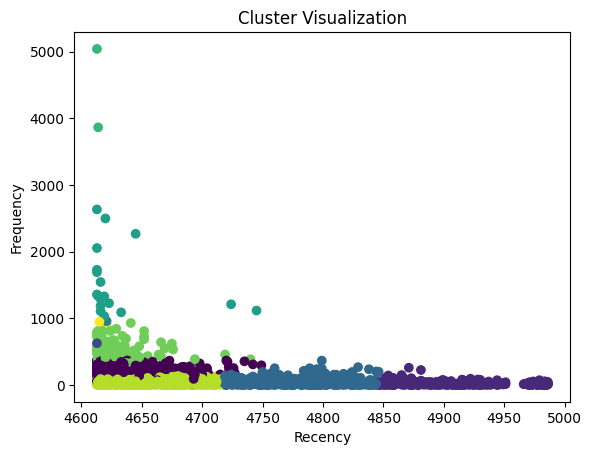

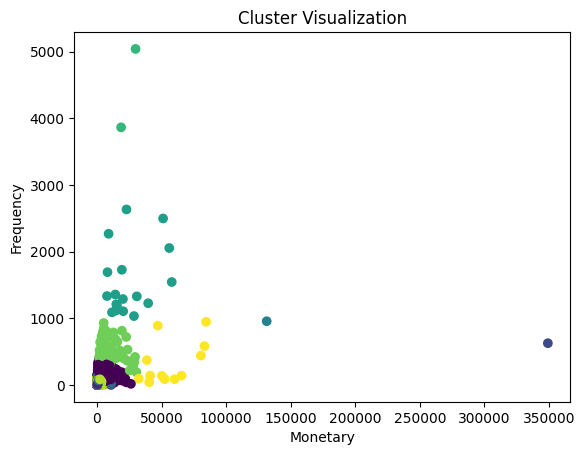

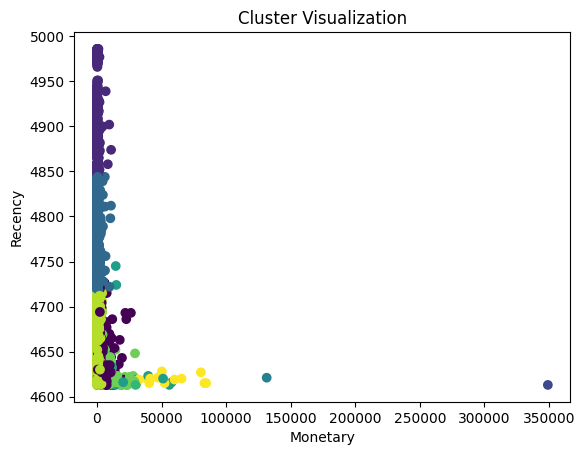

In [23]:
pandas_df = clusters.select("Recency", "Frequency", "Monetary", "prediction").toPandas()  # convert to Pandas DataFrame

plt.scatter(pandas_df["Recency"], pandas_df["Frequency"], c=pandas_df["prediction"], cmap="viridis")
plt.xlabel("Recency")
plt.ylabel("Frequency")
plt.title("Cluster Visualization")
plt.show()

plt.scatter(pandas_df["Monetary"], pandas_df["Frequency"], c=pandas_df["prediction"], cmap="viridis")
plt.xlabel("Monetary")
plt.ylabel("Frequency")
plt.title("Cluster Visualization")
plt.show()

plt.scatter(pandas_df["Monetary"], pandas_df["Recency"], c=pandas_df["prediction"], cmap="viridis")
plt.xlabel("Monetary")
plt.ylabel("Recency")
plt.title("Cluster Visualization")
plt.show()

Now that we have labeled our data through the clustering process, the next step involves training multiple machine learning models on the labeled data. Subsequently, we can compare the performances of these models to identify the most effective one for our specific task.

## Decision Tree

In [24]:
clusters.show()

+-----------+-------+---------+---------+--------------------+--------------------+----------+
|Customer ID|Recency|Frequency| Monetary|            features|      scaledFeatures|prediction|
+-----------+-------+---------+---------+--------------------+--------------------+----------+
|    12346.0|   4777|       33|   372.86|[4777.0,33.0,372....|[49.1650914958890...|         3|
|    12608.0|   4652|       16|   415.79|[4652.0,16.0,415....|[47.8785860663336...|         8|
|    12745.0|   4734|       22|   723.85|[4734.0,22.0,723....|[48.7225336281219...|         3|
|    12746.0|   4788|       17|   254.55|[4788.0,17.0,254....|[49.2783039736899...|         3|
|    12747.0|   4617|      154|5080.5303|[4617.0,154.0,508...|[47.5183645460581...|         0|
|    12748.0|   4613|     2634| 22879.66|[4613.0,2634.0,22...|[47.4771963723123...|         5|
|    12749.0|   4647|      139|  2806.48|[4647.0,139.0,280...|[47.8271258491514...|         0|
|    12777.0|   4705|       26|   519.45|[4705.0,2

To evaluate the model, we partition the data into training and testing sets.

In [25]:
(df_train, df_test) = clusters.randomSplit([0.7, 0.3], seed=seed)
print('Number of instances in the training set:', df_train.count())
print('Number of instances in the test set:', df_test.count())

Number of instances in the training set: 2845
Number of instances in the test set: 1126


In [26]:
in_train = df_train.selectExpr("features", "prediction as label")
in_train.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[4777.0,33.0,372....|    3|
|[4652.0,16.0,415....|    8|
|[4788.0,17.0,254....|    3|
|[4617.0,154.0,508...|    0|
|[4613.0,2634.0,22...|    5|
|[4705.0,26.0,519....|    8|
|[4859.0,7.0,128.0...|    1|
|[4642.0,13.0,4742.0]|    8|
|[4769.0,24.0,518....|    3|
|[4675.0,620.0,604...|    7|
|[4637.0,239.0,397...|    0|
|[4817.0,80.0,554....|    3|
|[4615.0,262.0,448...|    0|
|[4617.0,282.0,351...|    0|
|[4690.0,51.0,322....|    8|
|[4930.0,1.0,15.57...|    1|
|[4635.0,35.0,765....|    8|
|[4725.0,30.0,148....|    3|
|[4809.0,155.0,166...|    3|
|[4631.0,49.0,177....|    8|
+--------------------+-----+
only showing top 20 rows



To construct and train the Decision Tree Model, we begin by instantiating the DecisionTreeClassifier algorithm and configuring the relevant parameters. Subsequently, we proceed to fit the model using the training data, enabling it to learn from the provided dataset.

In [27]:
tree = DecisionTreeClassifier()
tree_model = tree.fit(in_train)
tree_model.transform(in_train).select("label","prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|    3|       3.0|
|    8|       8.0|
|    3|       3.0|
|    0|       0.0|
|    5|       7.0|
|    8|       8.0|
|    1|       1.0|
|    8|       8.0|
|    3|       3.0|
|    7|       7.0|
|    0|       0.0|
|    3|       3.0|
|    0|       0.0|
|    0|       0.0|
|    8|       8.0|
|    1|       1.0|
|    8|       8.0|
|    3|       3.0|
|    3|       3.0|
|    8|       8.0|
+-----+----------+
only showing top 20 rows



In [28]:
in_test = df_test.selectExpr("features", "prediction as label")
in_test.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[4734.0,22.0,723....|    3|
|[4647.0,139.0,280...|    0|
|[4706.0,19.0,540....|    8|
|[4645.0,101.0,174...|    8|
|[4613.0,75.0,1481...|    8|
|[4798.0,8.0,92.29...|    3|
|[4711.0,13.0,236....|    8|
|[4621.0,300.0,271...|    0|
|[4685.0,63.0,1315...|    8|
| [4652.0,14.0,799.0]|    8|
|[4630.0,118.0,488...|    0|
| [4923.0,16.0,208.0]|    1|
|[4629.0,97.0,2039...|    8|
|  [4693.0,2.0,330.0]|    8|
|[4675.0,70.0,1950...|    8|
|[4620.0,67.0,612....|    8|
|[4684.0,75.0,2581...|    8|
|  [4867.0,4.0,68.25]|    1|
|[4756.0,4.0,152.4...|    3|
|[4645.0,525.0,387...|    7|
+--------------------+-----+
only showing top 20 rows



After training the Decision Tree Model, the next step involves evaluating its performance on the test set. We apply the trained model to the test data and compute its accuracy to assess how well it generalizes to new, unseen examples.

In [29]:
tree_pred = tree_model.transform(in_test).select("label","prediction")
tree_pred.show()

+-----+----------+
|label|prediction|
+-----+----------+
|    3|       3.0|
|    0|       0.0|
|    8|       8.0|
|    8|       8.0|
|    8|       8.0|
|    3|       3.0|
|    8|       8.0|
|    0|       0.0|
|    8|       8.0|
|    8|       8.0|
|    0|       0.0|
|    1|       1.0|
|    8|       8.0|
|    8|       8.0|
|    8|       8.0|
|    8|       8.0|
|    8|       8.0|
|    1|       1.0|
|    3|       3.0|
|    7|       7.0|
+-----+----------+
only showing top 20 rows



In [30]:
tree_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
tree_accuracy = tree_evaluator.evaluate(tree_pred) * 100
print(f"Test accuracy: {tree_accuracy:.2f}%")

Test accuracy: 95.91%


## Random Forest Classifier

In [31]:
rf = RandomForestClassifier()
rf_model = rf.fit(in_train)
rf_model.transform(in_train).select("label","prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|    3|       3.0|
|    8|       8.0|
|    3|       3.0|
|    0|       0.0|
|    5|       7.0|
|    8|       8.0|
|    1|       1.0|
|    8|       8.0|
|    3|       3.0|
|    7|       7.0|
|    0|       0.0|
|    3|       3.0|
|    0|       0.0|
|    0|       0.0|
|    8|       8.0|
|    1|       1.0|
|    8|       8.0|
|    3|       3.0|
|    3|       3.0|
|    8|       8.0|
+-----+----------+
only showing top 20 rows



In [32]:
rf_pred = rf_model.transform(in_test).select("label","prediction")
rf_pred.show()

+-----+----------+
|label|prediction|
+-----+----------+
|    3|       3.0|
|    0|       0.0|
|    8|       8.0|
|    8|       8.0|
|    8|       8.0|
|    3|       3.0|
|    8|       8.0|
|    0|       0.0|
|    8|       8.0|
|    8|       8.0|
|    0|       0.0|
|    1|       1.0|
|    8|       8.0|
|    8|       8.0|
|    8|       8.0|
|    8|       8.0|
|    8|       8.0|
|    1|       1.0|
|    3|       3.0|
|    7|       7.0|
+-----+----------+
only showing top 20 rows



In [33]:
rf_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
rf_accuracy = rf_evaluator.evaluate(rf_pred) * 100
print(f"Test accuracy: {rf_accuracy:.2f}%")

Test accuracy: 95.83%


## Neural Network

In [34]:
layers = [3, 5, 5, 10] # specify the number of layers in the network
nn = MultilayerPerceptronClassifier(layers=layers, seed=seed)
nn_model = nn.fit(in_train)

In [35]:
nn_pred = nn_model.transform(in_test)
nn_pred = nn_pred.select("label","prediction")
nn_pred.show()

+-----+----------+
|label|prediction|
+-----+----------+
|    3|       8.0|
|    0|       0.0|
|    8|       8.0|
|    8|       8.0|
|    8|       8.0|
|    3|       8.0|
|    8|       8.0|
|    0|       0.0|
|    8|       8.0|
|    8|       8.0|
|    0|       0.0|
|    1|       8.0|
|    8|       8.0|
|    8|       8.0|
|    8|       8.0|
|    8|       8.0|
|    8|       8.0|
|    1|       8.0|
|    3|       8.0|
|    7|       0.0|
+-----+----------+
only showing top 20 rows



In [36]:
nn_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
nn_accuracy = nn_evaluator.evaluate(nn_pred) * 100
print(f"Test accuracy: {nn_accuracy:.2f}%")

Test accuracy: 62.70%
